In [1]:
%load_ext autoreload
%autoreload 2

from utils.sampling import stratified_spatial_sampling_dual
from utils.load import *

import torch
from torch_geometric.data import HeteroData

/opt/miniconda3/envs/fyp/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
weather_station_data = load_weather_station_dataset('weather_station_data.csv')
weather_station_locations = get_station_coordinate_mappings()

# Preprocess station data.
Some stations only contain rainfall information but some stations contain both rainfall and other information.
We will split these stations into weather station and general stations 

Additional info: 
  Windspeed
  Wind Direction
  Temperature
  Relative Humidity

In [3]:
cols = list(weather_station_data.columns)
cols.remove('time_sgt')
cols.remove('gid')
weather_station_df_pivot = pd.pivot(data=weather_station_data, index='time_sgt', columns='gid', values=cols)
weather_station_df_counts = weather_station_df_pivot.count().reset_index()

weather_station_info = pd.pivot(data=weather_station_df_counts, index='gid', columns = 'level_0')

pd.set_option('display.max_rows', None)

rainfall_station = [row[0] for row in weather_station_info.iterrows() if 0 in row[1].value_counts()]
general_station = [s for s in weather_station_locations if s not in rainfall_station]

print(rainfall_station)
print(general_station)

['S07', 'S08', 'S112', 'S113', 'S119', 'S123', 'S201', 'S203', 'S207', 'S208', 'S209', 'S210', 'S211', 'S213', 'S214', 'S215', 'S216', 'S217', 'S218', 'S219', 'S220', 'S221', 'S222', 'S223', 'S224', 'S226', 'S227', 'S228', 'S229', 'S230', 'S24', 'S29', 'S33', 'S40', 'S64', 'S66', 'S69', 'S71', 'S77', 'S78', 'S79', 'S81', 'S84', 'S88', 'S90', 'S900', 'S92', 'S94']
['S109', 'S50', 'S107', 'S43', 'S44', 'S121', 'S106', 'S111', 'S102', 'S60', 'S115', 'S104', 'S117', 'S116', 'S06']


In [4]:
pd.set_option('display.max_rows', 20)

general_station_data = {}
rainfall_station_data = {}
for station in weather_station_df_pivot.columns.get_level_values(1).unique():
    station_cols = weather_station_df_pivot.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    if station in general_station:
      general_station_data[station] = station_cols.values 
    else:
      rainfall_station_data[station] = station_cols.values[:, 0:1]

print(rainfall_station_data)

{'S07': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(26096, 1)), 'S08': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(26096, 1)), 'S112': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(26096, 1)), 'S113': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(26096, 1)), 'S119': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(26096, 1)), 'S123': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(26096, 1)), 'S201': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(26096, 1)), 'S203': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(26096, 1)), 'S207': array([[0.],
       [0.],
       [0.],
       ...

/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_85155/476523970.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = weather_station_df_pivot.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_85155/476523970.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = weather_station_df_pivot.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_85155/476523970.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = weather_station_df_pivot.xs(station, lev

In [5]:
data = HeteroData()

general_station_features = []
rainfall_station_features = []
for station in general_station:
  station_feat = general_station_data[station]
  general_station_features.append(station_feat)

for station in rainfall_station:
  station_feat = rainfall_station_data[station]
  rainfall_station_features.append(station_feat)

dtype = torch.float32
data['general_station'].x = torch.tensor(np.array(general_station_features).transpose(1, 0, 2), dtype=dtype)
data['rainfall_station'].x = torch.tensor(np.array(rainfall_station_features).transpose(1,0,2), dtype=dtype)

data['general_station'].y = torch.tensor(np.array(general_station_features)[:,:,0:1].transpose(1,0,2), dtype=dtype)
data['rainfall_station'].y = torch.tensor(np.array(rainfall_station_features).transpose(1,0,2), dtype=dtype)

print(data)

HeteroData(
  general_station={
    x=[26096, 15, 5],
    y=[26096, 15, 1],
  },
  rainfall_station={
    x=[26096, 48, 1],
    y=[26096, 48, 1],
  }
)


K-MEANS STRATIFIED SPATIAL SAMPLING
Total stations: 63
Number of clusters: 8
Random seed: 42

Split configuration:
  - Test (shared): 10%
  - Statistical train: 90%
  - ML train: 70%
  - ML validation: 20%

STEP 1: K-means Clustering
Clustering complete. Cluster centers:
  Cluster 0: (103.8462, 1.3725) - 10 stations
  Cluster 1: (103.7985, 1.2981) - 16 stations
  Cluster 2: (103.7629, 1.4271) - 8 stations
  Cluster 3: (103.9725, 1.3346) - 6 stations
  Cluster 4: (103.7146, 1.3484) - 6 stations
  Cluster 5: (103.8863, 1.3236) - 9 stations
  Cluster 6: (103.6885, 1.2463) - 3 stations
  Cluster 7: (103.9325, 1.3919) - 5 stations

STEP 2: Creating Shared Test Set (10%)
  Cluster 0: 10 stations → 1 test, 9 remaining
  Cluster 1: 16 stations → 1 test, 15 remaining
  Cluster 2: 8 stations → 1 test, 7 remaining
  Cluster 3: 6 stations → 1 test, 5 remaining
  Cluster 4: 6 stations → 1 test, 5 remaining
  Cluster 5: 9 stations → 1 test, 8 remaining
  Cluster 6: 3 stations → 1 test, 2 remaining
 

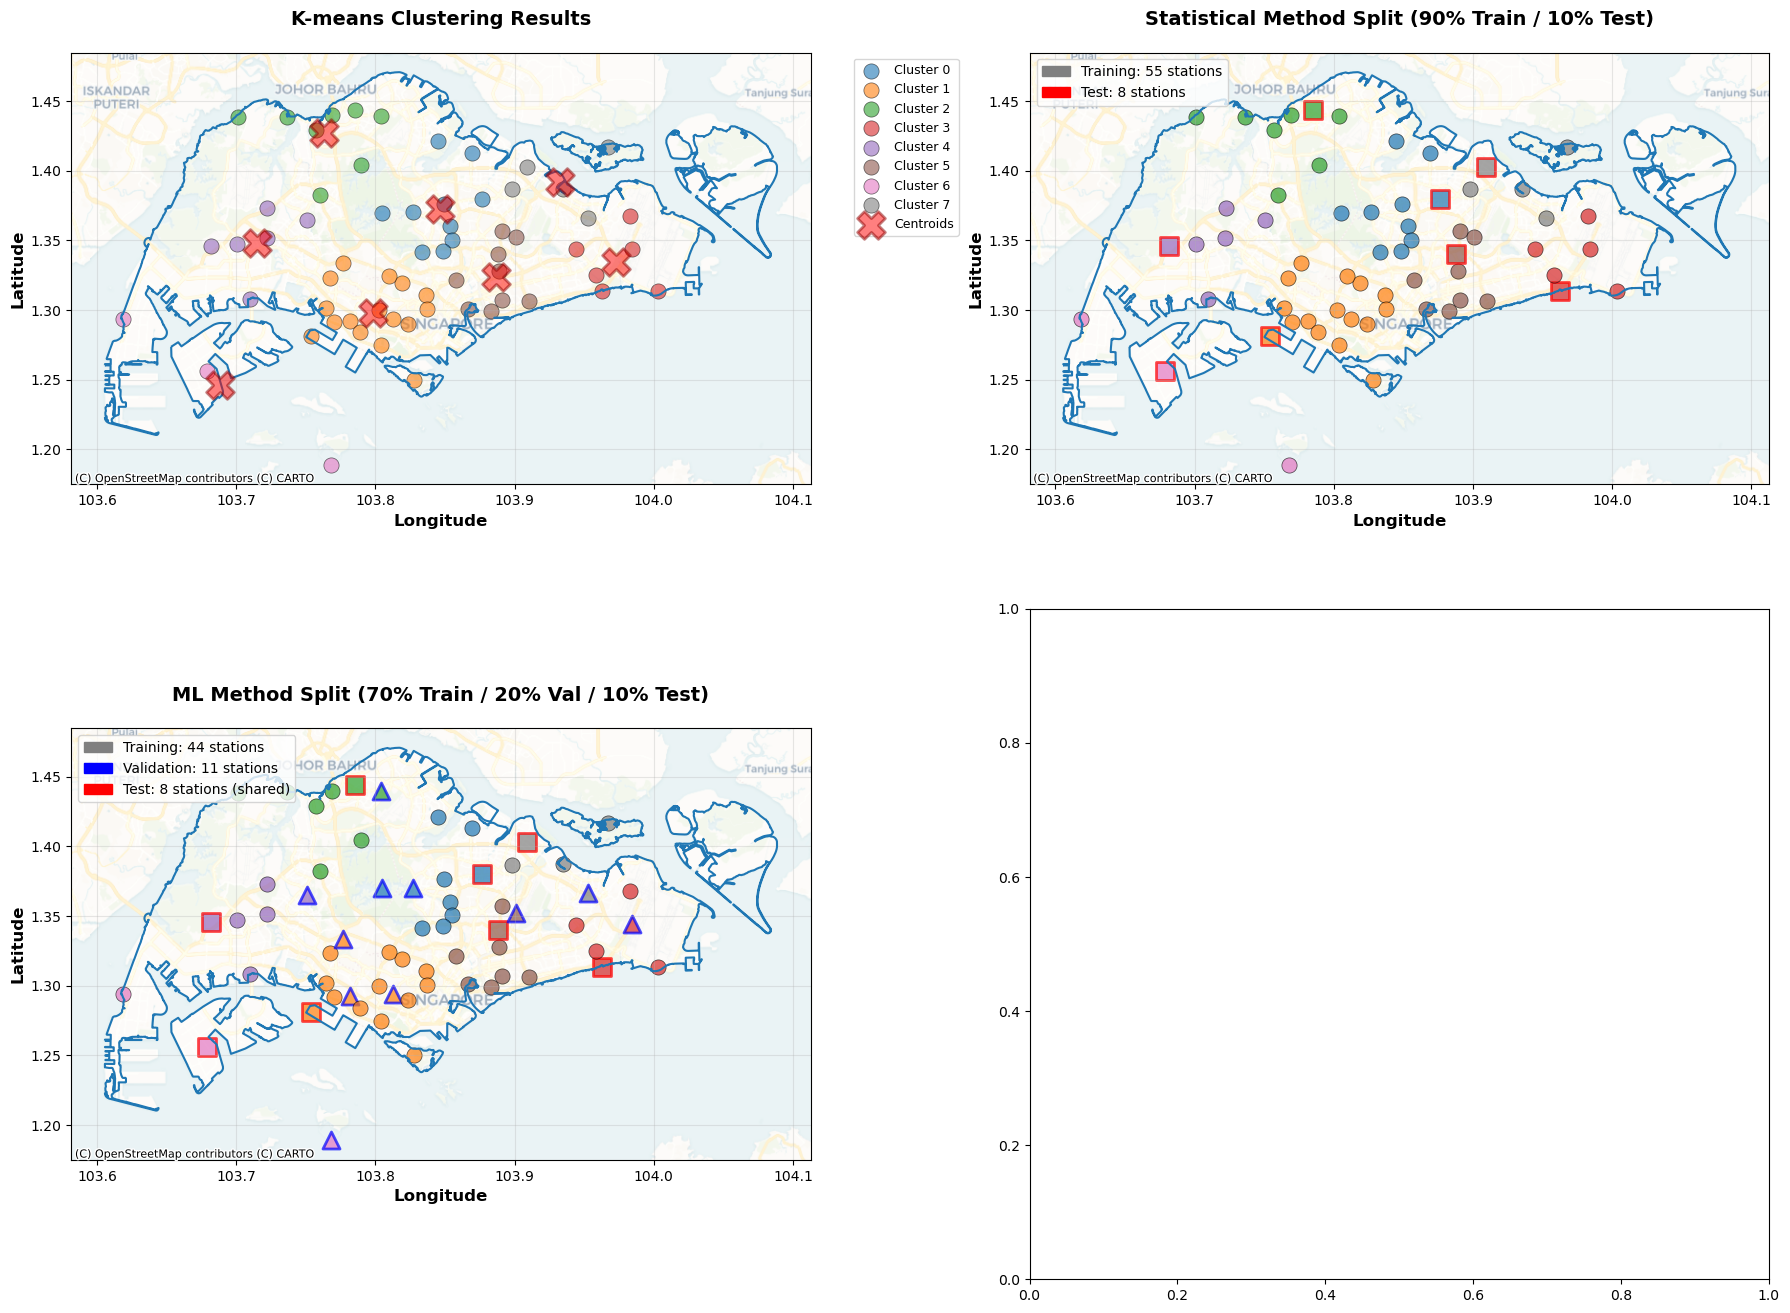

{'statistical': {'train': array(['S109', 'S88', 'S216', 'S08', 'S217', 'S209', 'S900', 'S07', 'S69',
       'S223', 'S79', 'S71', 'S60', 'S201', 'S226', 'S203', 'S92', 'S50',
       'S230', 'S111', 'S222', 'S90', 'S77', 'S213', 'S66', 'S64', 'S227',
       'S210', 'S211', 'S112', 'S40', 'S208', 'S24', 'S224', 'S207',
       'S84', 'S229', 'S228', 'S121', 'S33', 'S218', 'S221', 'S119',
       'S78', 'S113', 'S06', 'S215', 'S214', 'S123', 'S115', 'S102',
       'S106', 'S220', 'S29', 'S94'], dtype='<U4'), 'test': array(['S219', 'S116', 'S104', 'S107', 'S44', 'S43', 'S117', 'S81'],
      dtype='<U4')}, 'ml': {'train': array(['S216', 'S109', 'S217', 'S900', 'S07', 'S209', 'S88', 'S213',
       'S60', 'S92', 'S223', 'S222', 'S226', 'S111', 'S201', 'S79', 'S90',
       'S203', 'S230', 'S211', 'S112', 'S210', 'S64', 'S66', 'S40',
       'S208', 'S207', 'S24', 'S84', 'S33', 'S229', 'S228', 'S121',
       'S113', 'S119', 'S78', 'S214', 'S221', 'S215', 'S123', 'S115',
       'S106', 'S220', 'S29

In [6]:
split_info = stratified_spatial_sampling_dual(weather_station_locations)
print(split_info)

data['general_station'].train_mask = [1 if station in split_info['ml']['train'] else 0 for station in general_station]
data['general_station'].val_mask = [1 if station in split_info['ml']['validation'] else 0 for station in general_station]
data['general_station'].test_mask = [1 ^ (x | y) for x,y in zip(data['general_station'].train_mask, data['general_station'].val_mask)]

data['rainfall_station'].train_mask = [1 if station in split_info['ml']['train'] else 0 for station in rainfall_station]
data['rainfall_station'].val_mask = [1 if station in split_info['ml']['validation'] else 0 for station in rainfall_station]
data['rainfall_station'].test_mask = [1 ^ (x | y) for x,y in zip(data['rainfall_station'].train_mask, data['rainfall_station'].val_mask)]

print(data)

# Edge generation
We consider the location of the stations when performing our edge generation. 
General station locations and rainfall station locations will be considered the same and we will make a connection across the nodes if required. This will ensure that we can connect both the layers together in the graph.

In [7]:
#variable to determine number of neighbours per node
import networkx as nx
from sklearn.neighbors import NearestNeighbors
K = 4 

print(weather_station_locations)
ids = list(weather_station_locations.keys())
print(ids)
coords = np.array(list(weather_station_locations.values()))

knn = NearestNeighbors(n_neighbors=K+1, algorithm='ball_tree')
knn.fit(coords)

distances, indices = knn.kneighbors(coords)


G = nx.Graph()

edges = {
        'rainfall_to_rainfall': [],  
        'rainfall_to_general': [],    
        'general_to_rainfall': [],  
        'general_to_general': []      
    }

for idx, row in enumerate(indices):
  origin = row[0]
  for n in row[1:]: 
    if ids[origin] in rainfall_station:
      start_id = rainfall_station.index(ids[origin])
      if ids[n] in rainfall_station:
        end_id = rainfall_station.index(ids[n])
        edges['rainfall_to_rainfall'].append([start_id, end_id])
      else:
        end_id = general_station.index(ids[n])
        edges['rainfall_to_general'].append([start_id, end_id])
    else:
      start_id = general_station.index(ids[origin])
      if ids[n] in rainfall_station:
        end_id = rainfall_station.index(ids[n])
        edges['general_to_rainfall'].append([start_id, end_id])
      else:
        end_id = general_station.index(ids[n])
        edges['general_to_general'].append([start_id, end_id])

G.add_edges_from(edges['rainfall_to_rainfall'])

for key, val in edges.items():
  xarr = []
  yarr = []
  for x, y in val:
    xarr.append(x)
    yarr.append(y)
  edges[key] = [xarr, yarr]


data['general_station', 'gen_to_rain', 'rainfall_station'].edge_index = torch.tensor(edges['general_to_rainfall'], dtype=torch.int32)
data['rainfall_station', 'rain_to_gen', 'general_station'].edge_index = torch.tensor(edges['rainfall_to_general'], dtype=torch.int32)
data['general_station', 'gen_to_gen', 'general_station'].edge_index = torch.tensor(edges['general_to_general'], dtype=torch.int32)
data['rainfall_station', 'rain_to_rain', 'rainfall_station'].edge_index = torch.tensor(edges['rainfall_to_rainfall'], dtype=torch.int32)

print(data)

{'S224': (1.34392, 103.98409), 'S77': (1.2937, 103.8125), 'S216': (1.36019, 103.85335), 'S109': (1.3764, 103.8492), 'S217': (1.35041, 103.85526), 'S64': (1.3824, 103.7603), 'S90': (1.3191, 103.8191), 'S208': (1.3136, 104.00317), 'S201': (1.32311, 103.76714), 'S50': (1.3337, 103.7768), 'S220': (1.38666, 103.89797), 'S213': (1.32427, 103.8097), 'S107': (1.3135, 103.9625), 'S215': (1.32785, 103.88899), 'S222': (1.28987, 103.82364), 'S221': (1.35691, 103.89088), 'S33': (1.3081, 103.71), 'S229': (1.35167, 103.72195), 'S228': (1.34703, 103.70073), 'S71': (1.2923, 103.7815), 'S43': (1.3399, 103.8878), 'S211': (1.42918, 103.75711), 'S66': (1.4387, 103.7363), 'S112': (1.43854, 103.70131), 'S07': (1.3415, 103.8334), 'S226': (1.27472, 103.80389), 'S40': (1.4044, 103.78962), 'S223': (1.29984, 103.80264), 'S113': (1.30648, 103.9104), 'S44': (1.34583, 103.68166), 'S119': (1.30105, 103.8666), 'S121': (1.37288, 103.72244), 'S203': (1.29164, 103.7702), 'S29': (1.387, 103.935), 'S94': (1.3662, 103.9528)

# Creating the GNN

In [106]:
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero, HeteroConv, GCNConv, GATConv, Linear

class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('general_station', 'gen_to_gen', 'general_station'): GCNConv(-1, hidden_channels),
                ('general_station', 'gen_to_rain', 'rainfall_station'): SAGEConv((-1, -1), hidden_channels),
                ('rainfall_station', 'rain_to_gen', 'general_station'): SAGEConv((-1, -1), hidden_channels),
                ('rainfall_station', 'rain_to_rain', 'rainfall_station'): GCNConv(-1, hidden_channels),
            }, aggr='sum')
            self.convs.append(conv)

        self.lin_rainfall = Linear(hidden_channels, out_channels)
        self.lin_general = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()}

        gen_out = self.lin_general(x_dict['general_station'])
        rain_out = self.lin_rainfall(x_dict['rainfall_station'])
        combined = torch.cat([gen_out, rain_out], dim=1)
        return combined

model = HeteroGNN(hidden_channels=16, out_channels=1,
                  num_layers=3)

In [107]:
print(data)

HeteroData(
  general_station={
    x=[26096, 15, 5],
    y=[26096, 15, 1],
    train_mask=[15],
    val_mask=[15],
    test_mask=[15],
  },
  rainfall_station={
    x=[26096, 48, 1],
    y=[26096, 48, 1],
    train_mask=[48],
    val_mask=[48],
    test_mask=[48],
  },
  (general_station, gen_to_rain, rainfall_station)={ edge_index=[2, 50] },
  (rainfall_station, rain_to_gen, general_station)={ edge_index=[2, 40] },
  (general_station, gen_to_gen, general_station)={ edge_index=[2, 10] },
  (rainfall_station, rain_to_rain, rainfall_station)={ edge_index=[2, 152] }
)


In [ ]:
import torch
import torch.nn.functional as F
import tqdm as tqdm
import matplotlib.pyplot as plt

optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
training_loss_arr = []
test_loss_arr = []
for i in tqdm.tqdm(range(500)):
  model.train()
  optimizer.zero_grad()
  out = model(data.x_dict, data.edge_index_dict)

  general_station_mask = data['general_station'].train_mask
  rainfall_station_mask = data['rainfall_station'].train_mask

  training_loss = F.mse_loss(out[:, 0:15][:,general_station_mask], data['general_station'].y[:,general_station_mask]) + F.mse_loss(out[:, 15:][:,rainfall_station_mask], data['rainfall_station'].y[:,rainfall_station_mask])
  test_loss = F.mse_loss(out[:, 0:15][:,data['general_station'].test_mask], data['general_station'].y[:,data['general_station'].test_mask]) + F.mse_loss(out[:, 15:][:,data['rainfall_station'].test_mask], data['rainfall_station'].y[:,data['rainfall_station'].test_mask])
  
  training_loss_arr.append(float(training_loss))
  test_loss_arr.append(float(test_loss))
  training_loss.backward()
  optimizer.step()

print(training_loss_arr)
print(test_loss_arr)
plt.plot(training_loss_arr, label='validation_loss', color='blue')
plt.plot(test_loss_arr, label='test_loss', color='red')

  9%|▉         | 46/500 [01:13<13:26,  1.78s/it]

In [101]:
print(model)

HeteroGNN(
  (convs): ModuleList(
    (0-2): 3 x HeteroConv(num_relations=4)
  )
  (lin_rainfall): Linear(16, 1, bias=True)
  (lin_general): Linear(16, 1, bias=True)
)


In [102]:
print(test_loss_arr[-1])

0.18135228753089905


# Visualisation of output
Test event will be 02-05-2025 0415 to 0615


In [103]:
test_event_data = weather_station_df_pivot.iloc[1772:1798].resample('15min').first()
test_data = data.clone()

test_general_station_data = {}
test_rainfall_station_data = {}

for station in test_event_data.columns.get_level_values(1).unique():
    station_cols = test_event_data.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    if station in general_station:
      test_general_station_data[station] = station_cols.values 
    else:
      test_rainfall_station_data[station] = station_cols.values[:, 0:1]
# print(test_general_station_data)
# print(test_rainfall_station_data)

test_general_station_features = []
test_rainfall_station_features = []

for station in general_station:
  if station in test_general_station_data:
    station_feat = test_general_station_data[station]
    test_general_station_features.append(station_feat)

for station in rainfall_station:
  if station in test_rainfall_station_data:
    station_feat = test_rainfall_station_data[station]
    test_rainfall_station_features.append(station_feat)

# print(test_general_station_features)
# print(test_rainfall_station_features)

test_data['general_station'].x = torch.tensor(np.array(test_general_station_features).transpose(1,0,2), dtype=torch.float)
test_data['general_station'].y = torch.tensor(np.array(test_general_station_features)[:, :,0:1].transpose(1,0,2), dtype=torch.float)
test_data['rainfall_station'].x = torch.tensor(np.array(test_rainfall_station_features).transpose(1,0,2), dtype=torch.float) 
test_data['rainfall_station'].y = torch.tensor(np.array(test_rainfall_station_features).transpose(1,0,2), dtype=torch.float)  

out = model(test_data.x_dict, test_data.edge_index_dict)
print(out.detach().numpy()[0])

[[ 2.3734872e-01]
 [-1.2360960e-03]
 [ 5.2279568e-01]
 [-2.3141459e-02]
 [ 6.9835657e-01]
 [-1.4244820e+00]
 [ 1.0283862e-01]
 [           nan]
 [           nan]
 [           nan]
 [ 2.4217267e+00]
 [ 2.4509166e-01]
 [ 2.7370262e+00]
 [           nan]
 [-6.8848085e-01]
 [-3.1653520e-01]
 [ 1.2665692e-01]
 [ 9.7581595e-02]
 [-1.9946077e-01]
 [-2.3559579e-01]
 [-2.6133523e+00]
 [           nan]
 [           nan]
 [ 6.5506887e+00]
 [ 5.7213650e+00]
 [-3.2068193e-03]
 [-1.7523023e-01]
 [-7.4130464e-01]
 [ 6.3889295e-02]
 [-1.5455802e-01]
 [-1.0229099e+00]
 [ 1.1548162e+00]
 [ 9.3691379e-02]
 [ 1.4652441e+00]
 [ 3.6148643e+00]
 [-6.6009331e+00]
 [ 1.8915718e+00]
 [           nan]
 [           nan]
 [ 4.8365355e+00]
 [           nan]
 [ 2.1574524e-01]
 [ 1.2948909e+00]
 [ 6.0929370e-01]
 [           nan]
 [ 4.3284912e+00]
 [ 2.6272211e+00]
 [ 2.0018861e+00]
 [ 1.3812606e+00]
 [ 3.0675216e+00]
 [-3.3571470e-01]
 [ 6.7629254e-01]
 [           nan]
 [           nan]
 [ 5.9507060e-01]
 [        

/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_85155/603014944.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = test_event_data.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_85155/603014944.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = test_event_data.xs(station, level=1, axis=1).interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
/var/folders/h7/zmlpvml96rn3fnlg2qxg2nt80000gn/T/ipykernel_85155/603014944.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_cols = test_event_data.xs(station, level=1, axis=1).interpolate(m

# Visualise rain on radar grid
Hard coded to plot only consequitive 9 timestamps

In [104]:
print(out.detach().numpy()[0])

[[ 2.3734872e-01]
 [-1.2360960e-03]
 [ 5.2279568e-01]
 [-2.3141459e-02]
 [ 6.9835657e-01]
 [-1.4244820e+00]
 [ 1.0283862e-01]
 [           nan]
 [           nan]
 [           nan]
 [ 2.4217267e+00]
 [ 2.4509166e-01]
 [ 2.7370262e+00]
 [           nan]
 [-6.8848085e-01]
 [-3.1653520e-01]
 [ 1.2665692e-01]
 [ 9.7581595e-02]
 [-1.9946077e-01]
 [-2.3559579e-01]
 [-2.6133523e+00]
 [           nan]
 [           nan]
 [ 6.5506887e+00]
 [ 5.7213650e+00]
 [-3.2068193e-03]
 [-1.7523023e-01]
 [-7.4130464e-01]
 [ 6.3889295e-02]
 [-1.5455802e-01]
 [-1.0229099e+00]
 [ 1.1548162e+00]
 [ 9.3691379e-02]
 [ 1.4652441e+00]
 [ 3.6148643e+00]
 [-6.6009331e+00]
 [ 1.8915718e+00]
 [           nan]
 [           nan]
 [ 4.8365355e+00]
 [           nan]
 [ 2.1574524e-01]
 [ 1.2948909e+00]
 [ 6.0929370e-01]
 [           nan]
 [ 4.3284912e+00]
 [ 2.6272211e+00]
 [ 2.0018861e+00]
 [ 1.3812606e+00]
 [ 3.0675216e+00]
 [-3.3571470e-01]
 [ 6.7629254e-01]
 [           nan]
 [           nan]
 [ 5.9507060e-01]
 [        

The size of dataset is 9
0.23734872043132782
-0.0012360960245132446
0.5227956771850586
-0.02314145863056183
0.698356568813324
-1.424481987953186
0.10283862054347992
nan
nan
nan
2.421726703643799
0.24509166181087494
2.7370262145996094
nan
-0.6884808540344238
-0.31653520464897156
0.1266569197177887
0.09758159518241882
-0.19946077466011047
-0.23559579253196716
-2.6133522987365723
nan
nan
6.550688743591309
5.721364974975586
-0.0032068192958831787
-0.1752302348613739
-0.7413046360015869
0.06388929486274719
-0.15455801784992218
-1.0229098796844482
1.1548161506652832
0.0936913788318634
1.4652440547943115
3.6148643493652344
-6.600933074951172
1.8915717601776123
nan
nan
4.836535453796387
nan
0.2157452404499054
1.2948908805847168
0.6092936992645264
nan
4.3284912109375
2.62722110748291
2.0018861293792725
1.381260633468628
3.067521572113037
-0.3357146978378296
0.6762925386428833
nan
nan
0.5950706005096436
nan
2.2239596843719482
0.5520303249359131
-0.13157778978347778
nan
0.2767274081707001
nan
4.8

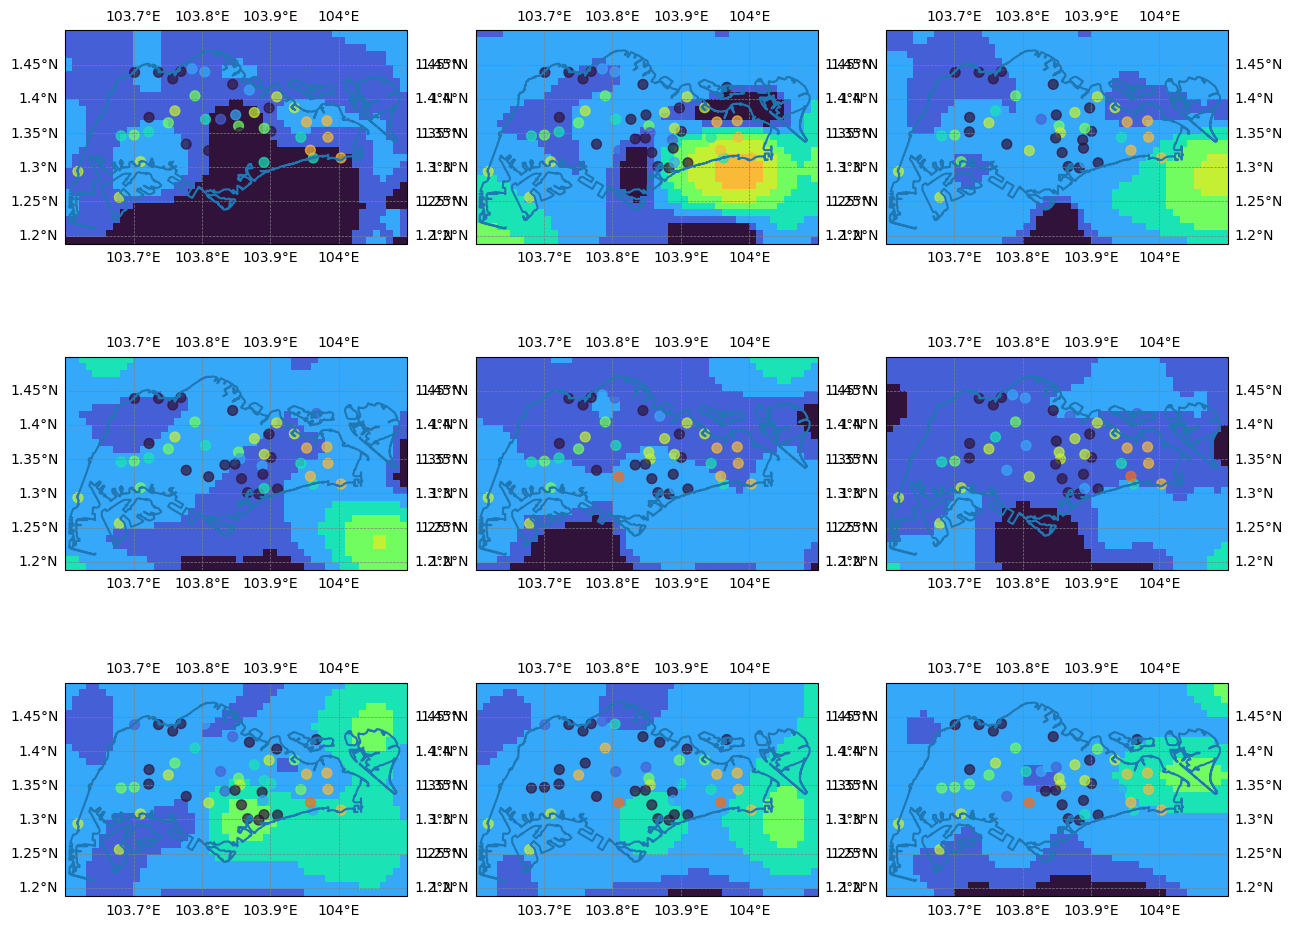

In [105]:
from utils.load import *
from utils.visualisation import *
radar_df = load_radar_dataset('radar_vis')

fig, ax = plt.subplots(3,3, figsize=(15,12), subplot_kw={'projection' : ccrs.PlateCarree()})

bounds_singapore = {
  'left': 103.6,
  'right': 104.1,
  'top': 1.5,
  'bottom': 1.188
}
bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20] 
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

for idx, timestamp in enumerate(out):
  output = {}
  count = 0
  
  for stn in general_station:
    output[stn] = float(timestamp[count])
    count += 1
  for stn in rainfall_station:
    output[stn] = float(timestamp[count])
    count += 1
  axi = ax[idx // 3][idx % 3]
  node_df = pd.Series(output)
  node_df = pandas_to_geodataframe(node_df)

  visualise_gauge_grid(node_df=node_df, ax=axi)
  improved_visualise_radar_grid(radar_df.iloc[idx], ax=axi, zoom=bounds_singapore, norm=norm)
  visualise_singapore_outline(ax=axi)

In [ ]:
original_rainfall_rates = weather_station_df_pivot.iloc[1773:1797].resample('15min').first()['rain_rate']


print(original_rainfall_rates)

gid                  S06  S07  S08  S102  S104  S106  S107  S109  S111  S112  \
time_sgt                                                                       
2025-02-05 04:15:00  0.0  0.2  0.0   NaN   0.2   0.2   0.2   0.2   0.0   0.2   
2025-02-05 04:30:00  0.2  0.2  0.2   NaN   0.0   0.4   0.4   0.2   0.0   0.2   
2025-02-05 04:45:00  0.2  0.2  0.2   NaN   0.2   0.4   0.6   0.2   0.2   0.0   
2025-02-05 05:00:00  0.2  0.0  0.2   NaN   0.0   0.6   0.6   0.2   0.2   0.2   
2025-02-05 05:15:00  0.4  0.0  0.0   NaN   0.0   0.4   0.4   0.2   0.0   0.2   
2025-02-05 05:30:00  0.4  0.2  0.2   NaN   0.0   0.4   0.4   0.2   0.2   0.2   
2025-02-05 05:45:00  0.4  0.0  0.0   NaN   0.2   0.4   0.4   0.2   0.0   0.0   
2025-02-05 06:00:00  0.2  0.0  0.2   NaN   0.0   0.2   0.2   0.0   0.0   0.0   
2025-02-05 06:15:00  0.2  0.2  0.2   NaN   0.2   0.2   0.2   0.2   0.0   0.0   

gid                  ...  S77  S78  S79  S81  S84  S88  S90  S900  S92  S94  
time_sgt             ...                 

In [43]:
print(out)

tensor([[[ 3.0978e-01],
         [ 1.1096e-01],
         [ 1.1057e+00],
         [ 2.1564e+00],
         [ 2.2207e+00],
         [ 2.2576e+00],
         [ 7.8573e-01],
         [        nan],
         [        nan],
         [        nan],
         [ 1.0618e+00],
         [ 1.8754e-01],
         [ 1.2496e+00],
         [        nan],
         [ 3.2989e+00],
         [ 3.5357e-01],
         [ 8.4221e-02],
         [-2.1330e-01],
         [-1.2958e-01],
         [ 1.4872e-01],
         [ 3.0600e+00],
         [        nan],
         [        nan],
         [ 2.5351e+00],
         [ 2.3158e+00],
         [-1.5070e-01],
         [ 9.6075e-01],
         [ 9.8244e-01],
         [ 1.5046e+00],
         [-8.0050e-01],
         [ 2.3559e+00],
         [-5.2070e-01],
         [-6.0949e-02],
         [ 3.7376e-01],
         [-1.1134e+00],
         [ 3.6087e+00],
         [ 4.3263e+00],
         [        nan],
         [        nan],
         [ 1.3650e+00],
         [        nan],
         [ 8.920

In [70]:
actual_arr = []
pred_arr = []

for idx, timestamp in enumerate(out):
  output = {}
  count = 0
  a_arr = []
  p_arr = []
  
  for stn in general_station:
    output[stn] = float(timestamp[count])
    count += 1
  for stn in rainfall_station:
    output[stn] = float(timestamp[count])
    count += 1

  for key, value in output.items():
    a_arr.append(original_rainfall_rates.iloc[idx][key])
    p_arr.append(output[key])
  a_arr = list(map(lambda x: float(x), a_arr))
  actual_arr.append(a_arr)
  pred_arr.append(p_arr)

actual_arr = np.array(actual_arr)
pred_arr = np.array(pred_arr)

print(actual_arr)
print(pred_arr)
error = []
for i in range(len(actual_arr)):
  error.append(np.nanmean(actual_arr - pred_arr) ** 2)

MSE = np.mean(np.array(error))
print(MSE)


[[0.2   0.    0.2   0.2   0.    0.    0.2   0.      nan 0.    0.    0.2
  0.    0.    0.    0.2   0.    0.2   0.    0.    0.    0.    0.    0.402
  0.204 0.202 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.4   0.4   0.
  0.    0.    0.    0.    0.    0.    0.    0.2   0.2   0.2   0.    0.
  0.4   0.    0.2  ]
 [0.2   0.    0.4   0.    0.    0.    0.4   0.      nan 0.    0.    0.
  0.    0.    0.2   0.2   0.2   0.2   0.    0.    0.    0.2   0.    0.603
  0.612 0.202 0.201 0.203 0.    0.    0.203 0.    0.197 0.204 0.201 0.203
  0.    0.    0.203 0.    0.    0.    0.    0.203 0.    0.4   0.2   0.
  0.2   0.    0.    0.2   0.    0.    0.2   0.2   0.2   0.4   0.    0.
  0.4   0.    0.2  ]
 [0.2   0.    0.6   0.2   0.    0.    0.4   0.2     nan 0.    0.    0.2
  0.    0.    0.2   0.2   0.2   0.    0.    0.2   0.    0.    0.    0.603
  0.408 0.202 0.    0.    0.    0.    0.203 0.    0.    0.204 0.201 0.203
  0.198 0.    0.  

In [52]:
print(original_rainfall_rates.iloc[0])

gid
S06     0.0
S07     0.2
S08     0.0
S102    NaN
S104    0.2
       ... 
S88     0.0
S90     0.0
S900    0.4
S92     0.0
S94     0.2
Name: 2025-02-05 04:15:00, Length: 63, dtype: float64
